<a href="https://colab.research.google.com/github/niroojen-thambimuthu/SAIT-475/blob/master/image_classification_Runtime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! zip -s- "/content/drive/My Drive/DATA-475/plant-seedlings-classification.zip" -O plant-seedlings-classification.zip
! unzip plant-seedlings-classification.zip -d plant-seedlings-classification

Streaming output truncated to the last 5000 lines.
  inflating: plant-seedlings-classification/test/b215531dd.png  
  inflating: plant-seedlings-classification/test/b2706e2b3.png  
  inflating: plant-seedlings-classification/test/b29339405.png  
  inflating: plant-seedlings-classification/test/b30ab4659.png  
  inflating: plant-seedlings-classification/test/b31292706.png  
  inflating: plant-seedlings-classification/test/b341d0aab.png  
  inflating: plant-seedlings-classification/test/b39c71707.png  
  inflating: plant-seedlings-classification/test/b3d6fdb80.png  
  inflating: plant-seedlings-classification/test/b3e08b037.png  
  inflating: plant-seedlings-classification/test/b47691c08.png  
  inflating: plant-seedlings-classification/test/b4c3df835.png  
  inflating: plant-seedlings-classification/test/b4f7c9214.png  
  inflating: plant-seedlings-classification/test/b573b7a56.png  
  inflating: plant-seedlings-classification/test/b5c7fd009.png  
  inflating: plant-seedlings-classifica

In [3]:
import os
import warnings
warnings.filterwarnings("ignore")

labels = os.listdir("plant-seedlings-classification/train")
print(labels)

['Fat Hen', 'Scentless Mayweed', 'Small-flowered Cranesbill', 'Common wheat', 'Shepherds Purse', 'Common Chickweed', 'Cleavers', 'Maize', 'Sugar beet', 'Loose Silky-bent', 'Black-grass', 'Charlock']


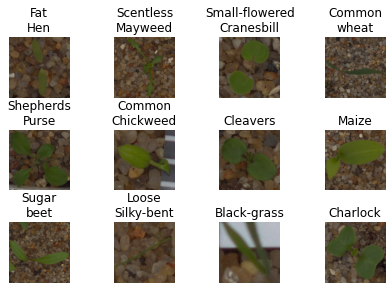

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


fig, axs = plt.subplots(nrows=3, ncols=4)
fig.tight_layout()
for index, label in enumerate(labels):
    image = np.random.choice(os.listdir(f"plant-seedlings-classification/train/{label}"))
    im = Image.open(f"plant-seedlings-classification/train/{label}/{image}")
    ind = int(index/4), index % 4
    axs[ind].imshow(im)
    axs[ind].set_title(label.replace(" ", "\n"))
    axs[ind].axis("off")

In [5]:
from fastai.vision import *
from fastai.metrics import accuracy

# Use from_folder factory method from ImageDataBunch to create a dataset
# configure: 
#   path
#   size
#   ds_tfms, to flip the image randomly and allow fliping vertically
#   valid_pct， 20%

path = "/content/plant-seedlings-classification"
# size = 224
# bs = 64

# data = ImageDataBunch.from_folder(
#     path,
#     train="train",
#     test="test",
#     ds_tfms=get_transforms(do_flip=True, flip_vert=True),
#     valid_pct=.2,
#     size=size,
#     bs=bs
# )

data = ImageDataBunch.from_folder(
    "/content/plant-seedlings-classification",
    train="train",
    test="test",
    ds_tfms=get_transforms(do_flip=True, flip_vert=True),
    valid_pct=.2,
    size=224,
    bs=64,
)

In [6]:
# normalize with imagenet_stats
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (3800 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Fat Hen,Fat Hen,Fat Hen,Fat Hen,Fat Hen
Path: /content/plant-seedlings-classification;

Valid: LabelList (950 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Black-grass,Small-flowered Cranesbill,Common Chickweed,Small-flowered Cranesbill,Loose Silky-bent
Path: /content/plant-seedlings-classification;

Test: LabelList (794 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/plant-seedlings-classification

In [7]:
# create a CNN learner named "learner" with resnet34
learner = cnn_learner(data, models.resnet34, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 1.20E-02


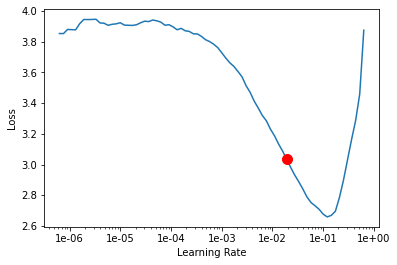

In [8]:
# find a learning rate
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [9]:
# fit one cycle
lr = learner.recorder.min_grad_lr
learner.fit_one_cycle(8, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.426701,0.508481,0.823158,01:34
1,0.875164,1.292635,0.663158,01:36
2,0.783625,0.678987,0.800000,01:37
3,0.588698,0.703902,0.789474,01:39
4,0.401247,0.236226,0.907368,01:38
5,0.302292,0.204980,0.931579,01:39
6,0.221462,0.139116,0.957895,01:39
7,0.189157,0.121426,0.953684,01:40


In [10]:
# interpret the result and see the most confused classess
interp = ClassificationInterpretation.from_learner(learner)
interp.most_confused(min_val=2)

[('Black-grass', 'Loose Silky-bent', 17),
 ('Loose Silky-bent', 'Black-grass', 9),
 ('Shepherds Purse', 'Scentless Mayweed', 4),
 ('Fat Hen', 'Sugar beet', 2),
 ('Maize', 'Common wheat', 2)]

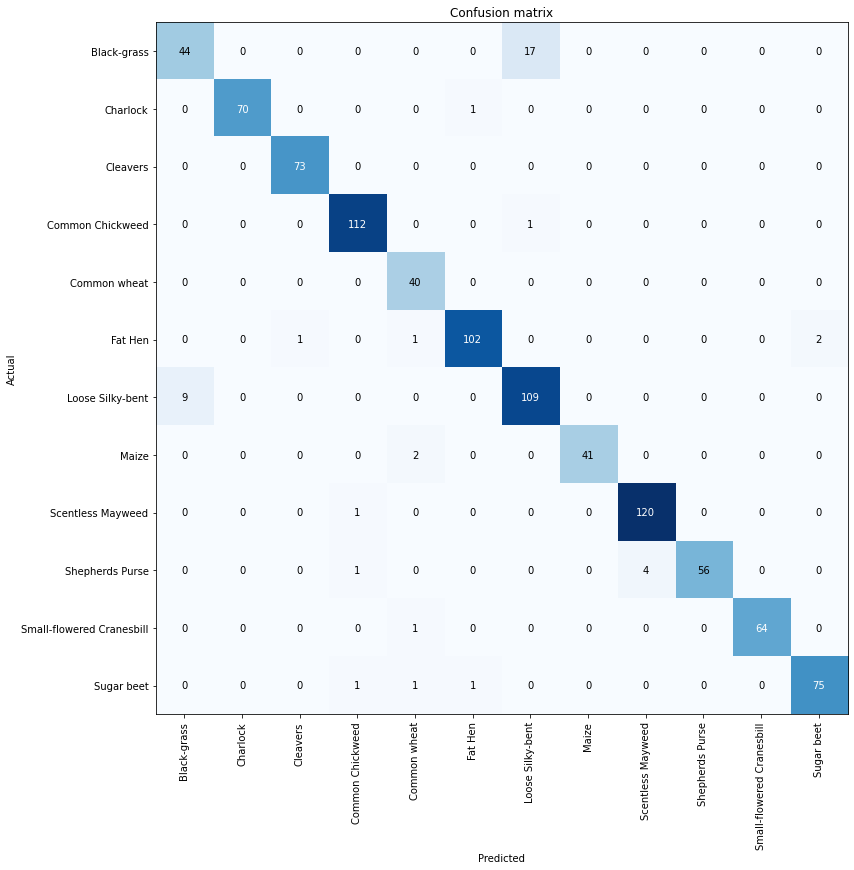

In [11]:
# fine tune the model and check the result again
interp.plot_confusion_matrix(figsize=(12, 12))